**Maize Leaf Classification - Corn or Maize Leaf Disease Dataset**

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline
from tensorflow.keras import layers
from tensorflow.keras import models
import os
from PIL import * 
import tensorflow as tf
from keras import optimizers
from keras import applications
from keras import backend as K
from os import listdir, makedirs
from keras.utils.data_utils import Sequence
from os.path import join, exists, expanduser
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
#from keras.applications import ResNet50
from keras.applications.resnet import ResNet50
from keras.utils.vis_utils import plot_model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_dir = r'/content/drive/MyDrive/Juru Sytems/dataset/'

In [3]:
classes = os.listdir(dataset_dir)
def display_four_class_images(random_number):
    for i in classes:
        new_dir = dataset_dir + i
        random_image = os.listdir(new_dir)[random_number]
        print(new_dir + '/' +random_image)
        plt.imshow(cv2.imread(new_dir + '/' + random_image)[:,:,::-1])
        plt.show()

NameError: ignored

/content/drive/MyDrive/Juru Sytems/dataset/Blight/Corn_Blight (46).jpg


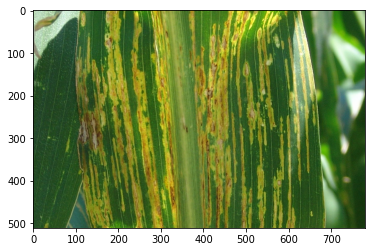

/content/drive/MyDrive/Juru Sytems/dataset/Common_Rust/Corn_Common_Rust (409).JPG


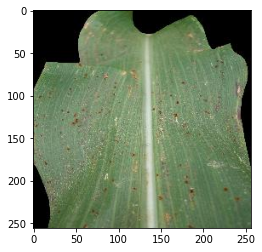

/content/drive/MyDrive/Juru Sytems/dataset/Healthy/Corn_Health (174).jpg


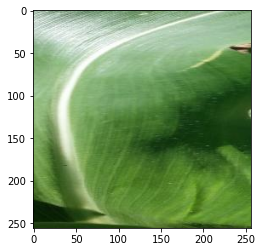

/content/drive/MyDrive/Juru Sytems/dataset/Gray_Leaf_Spot/Corn_Gray_Spot (146).JPG


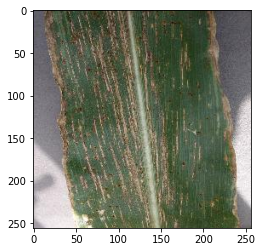

In [ ]:
display_four_class_images(100)

In [ ]:
im = cv2.imread('/content/drive/MyDrive/Juru Sytems/dataset/Gray_Leaf_Spot/Corn_Gray_Spot (106).JPG')
im.shape

(256, 256, 3)

In [ ]:
im.dtype

dtype('uint8')

In [ ]:
im

array([[[151, 151, 163],
        [151, 151, 163],
        [145, 145, 157],
        ...,
        [206, 207, 211],
        [196, 197, 201],
        [184, 185, 189]],

       [[151, 151, 163],
        [152, 152, 164],
        [148, 148, 160],
        ...,
        [193, 194, 198],
        [192, 193, 197],
        [198, 199, 203]],

       [[140, 140, 152],
        [144, 144, 156],
        [145, 145, 157],
        ...,
        [188, 189, 193],
        [193, 194, 198],
        [197, 198, 202]],

       ...,

       [[140, 143, 158],
        [142, 145, 160],
        [145, 148, 163],
        ...,
        [161, 159, 171],
        [160, 158, 170],
        [157, 155, 167]],

       [[144, 147, 162],
        [145, 148, 163],
        [147, 150, 165],
        ...,
        [170, 166, 178],
        [168, 164, 176],
        [164, 160, 172]],

       [[141, 144, 159],
        [142, 145, 160],
        [142, 145, 160],
        ...,
        [168, 164, 176],
        [165, 161, 173],
        [160, 156, 168]]

# **Count of Images in each class**

>



In [ ]:
def dataset_size(dataset_dir, classes):
    size = []
    for i in classes:
        size.append(len(os.listdir(dataset_dir + i)))
        
    df = pd.DataFrame(columns = ['Type', 'No_of_Images'])
    df['Type'] = classes
    df['No_of_Images'] = size
    
    return df

In [ ]:
dataset_size(dataset_dir, classes)
#Training Segmentation 500+1306+1162+574
#print(b*.7, b*.2, b*.1)



,Type,No_of_Images
0,Blight,1146
1,Common_Rust,1306
2,Healthy,1162
3,Gray_Leaf_Spot,574


# **Load and check the average image size of each class to make sure that there's no outlier shape in the Dataset.**

In [ ]:
def average_image_size(label_name):
    r, g, b = [], [], []
    for image in os.listdir(dataset_dir + label_name):
        im = cv2.imread(dataset_dir + label_name+'/'+image)
        r.append(im.shape[0])
        g.append(im.shape[1])
        b.append(im.shape[2])
        
    return (sum(r)/len(r), sum(g)/len(g), sum(b)/len(b))

In [ ]:
for label in classes:
    print(label, average_image_size(label))

NameError: ignored

# **Image Extensions**

In [ ]:
def image_extensions(label_name):
    extension = []
    for image in os.listdir(dataset_dir + label_name):
        extension.append(image.split('.')[-1])
        
    return list(set(extension))

In [ ]:
for label in classes:
    print(label, image_extensions(label))

Blight ['JPG', 'jpg', 'jpeg']
Common_Rust ['JPG', 'jpg']
Healthy ['JPG', 'jpg']
Gray_Leaf_Spot ['JPG', 'jpg']


In [ ]:
train_data_generator =  ImageDataGenerator(rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                validation_split = 0.25)

In [ ]:
train_dataset = train_data_generator.flow_from_directory(
                                    dataset_dir,
                                    target_size = (224, 224),
                                    class_mode = "categorical",
                                    batch_size = 64,
                                    subset = "training")

val_dataset = train_data_generator.flow_from_directory(
                                    dataset_dir,
                                    target_size = (224, 224),
                                    class_mode = "categorical",
                                    batch_size = 64,
                                    subset = "validation")

Found 3143 images belonging to 4 classes.
Found 1045 images belonging to 4 classes.


In [ ]:
def visualize_datagenerator(no_of_images):
    for pic in range(no_of_images):
        image, label = val_dataset.next()
        print("image shape is: ", image.shape)
        plt.imshow(image[0])
        print(image[20].shape)
        plt.show()

image shape is:  (64, 224, 224, 3)
(224, 224, 3)


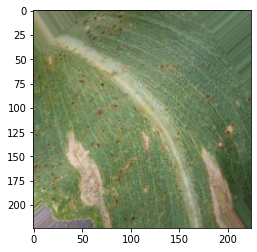

image shape is:  (64, 224, 224, 3)
(224, 224, 3)


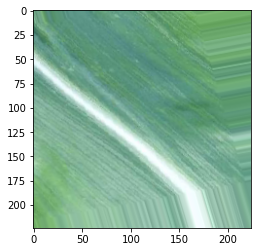

image shape is:  (64, 224, 224, 3)
(224, 224, 3)


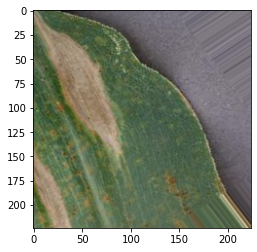

image shape is:  (64, 224, 224, 3)
(224, 224, 3)


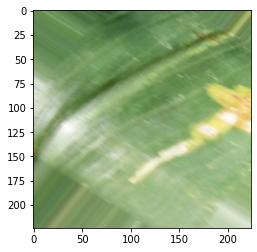

image shape is:  (64, 224, 224, 3)
(224, 224, 3)


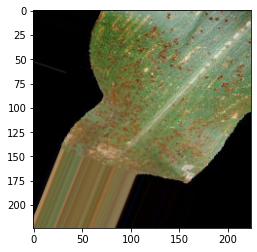

image shape is:  (64, 224, 224, 3)
(224, 224, 3)


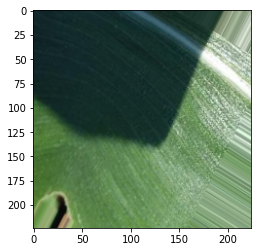

image shape is:  (64, 224, 224, 3)
(224, 224, 3)


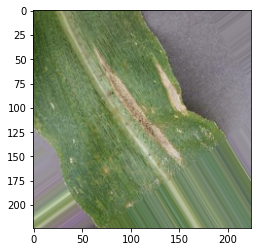

image shape is:  (64, 224, 224, 3)
(224, 224, 3)


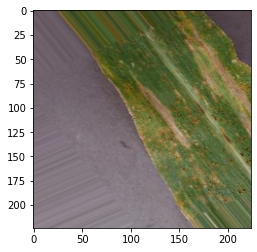

In [ ]:
visualize_datagenerator(8)

In [ ]:
input_layer = Input(shape = (224, 224, 3))

resnet50_output = ResNet50(
    include_top=True,
    weights=None,
    classes=train_dataset.num_classes
)(input_layer)

In [ ]:
resnet50_model = keras.Model(input_layer, resnet50_output)

NameError: ignored

In [ ]:
resnet50_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
resnet50_model.summary()

In [ ]:
plot_model(resnet50_model, to_file='resnet50model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = resnet50_model.fit(train_dataset, epochs = 1, validation_data = val_dataset, verbose = True)

In [ ]:
history

In [ ]:
history.history["loss"]

In [ ]:
def visualize_training_epochs(v):
    plt.plot(v.history["accuracy"])
    plt.plot(v.history["val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Resnet50_model_accuracy")
    plt.legend(["Train", "Validation"])
    plt.show()
    
    plt.plot(v.history["loss"])
    plt.plot(v.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Resnet50_model_loss")
    plt.legend(["Train", "Validation"])
    plt.show()

In [ ]:
visualize_training_epochs(history)

In [ ]:
resnet50_model.save("resnet_50.h5")

In [ ]:
val_dataset.class_indices

In [ ]:
val_dataset.classes

In [ ]:
len(val_dataset)

In [ ]:
predictions = resnet50_model.predict_generator(val_dataset)
predictions

In [ ]:
prediction_class = np.argmax(predictions, axis = 1)
prediction_class

In [ ]:
len(prediction_class)

In [ ]:
print(confusion_matrix(val_dataset.classes, prediction_class))

In [ ]:
print(classification_report(val_dataset.classes, prediction_class))